## Выбор и обучене DL-модели

In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Загрузка подготовленного датасета
df = pd.read_csv('final_df.csv', sep=';')
df.head()

,tree_dbh,health,curb_loc_OnCurb,steward_3or4,steward_4orMore,steward_No,guards_Helpful,guards_No,guards_Unsure,sidewalk_NoDamage,root_stone_Yes,root_grate_Yes,trunk_wire_Yes,trnk_light_Yes,brch_light_Yes,brch_other_Yes,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,0.007059,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,0.049412,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2,0.007059,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0.023529,2,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
4,0.049412,2,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [3]:
# Разделение датасета на признаки и таргет
X = df.drop('health', axis=1)
y = df['health']

In [5]:
le_target = LabelEncoder()
y = le_target.fit_transform(y)

In [4]:
# Разделение выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
X_train.head()

,tree_dbh,curb_loc_OnCurb,steward_3or4,steward_4orMore,steward_No,guards_Helpful,guards_No,guards_Unsure,sidewalk_NoDamage,root_stone_Yes,root_grate_Yes,trunk_wire_Yes,trnk_light_Yes,brch_light_Yes,brch_other_Yes,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
177416,0.007059,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
100304,0.032941,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
354938,0.002353,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
458057,0.058824,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
345866,0.030588,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [7]:
# Рассчитаем веса классов, т.к. присутсвует дизбаланс классов в таргетной переменной
class_counts = Counter(y_train)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32)

In [10]:
# Создание кастомного класса для датасета
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
# Определение тренировочного и тестового датасета
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [12]:
# Создание тренировочного и тестового лоадеров, для обучения DL-модели
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

## 📌 Обоснование выбора архитектуры MLP

Для решения задачи классификации состояния деревьев (3 класса: *Good, Fair, Poor*) была выбрана многослойная перцептронная (MLP) модель.  
Ниже приведены основные аргументы в пользу этого выбора:

### 🔹 Почему MLP?  
✅ **Подходит для табличных данных**: В отличие от сверточных (CNN) или рекуррентных (RNN) сетей, MLP хорошо работает с табличными признаками.  
✅ **Обрабатывает числовые и категориальные признаки**: Полносвязные слои позволяют эффективно обучать зависимости в данных.  

### 🔹 Архитектура модели  
- **4 полносвязных слоя** – достаточная глубина для улавливания сложных зависимостей, но без избыточной сложности.  
- **Dropout** – предотвращает переобучение за счет случайного отключения нейронов во время обучения.  
- **Активация ReLU** – ускоряет сходимость модели, устраняя проблему исчезающего градиента.  
- **Функция потерь CrossEntropyLoss** – стандартный выбор для многоклассовой классификации.  
- **Оптимизатор Adam** – адаптивно настраивает скорости обучения, улучшая сходимость.  

### 🔹 Итог  
MLP – это простой, но эффективный выбор для классификации деревьев по табличным данным. Архитектура модели сбалансирована для точности и скорости обучения.

In [29]:
# Определение архитектуры модели
class SimpleMLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [34]:
# Определение параметров модели и обучения
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))

In [35]:
# Просмотр девайса
device

device(type='cuda', index=0)

In [36]:
# Определение модели, функции потерь и оптимизатора
model = SimpleMLPModel(input_dim, output_dim).to(device)
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Обучение модели
def train_model(model, criterion, optimizer, train_loader, epochs=20):
    """Function for train DL-model"""
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [45]:
# Обучение модели
train_model(model, criterion, optimizer, train_loader, epochs=30)

Epoch 1/30, Loss: 1.0839
Epoch 2/30, Loss: 1.0714
Epoch 3/30, Loss: 1.0689
Epoch 4/30, Loss: 1.0674
Epoch 5/30, Loss: 1.0668
Epoch 6/30, Loss: 1.0660
Epoch 7/30, Loss: 1.0658
Epoch 8/30, Loss: 1.0652
Epoch 9/30, Loss: 1.0646
Epoch 10/30, Loss: 1.0646
Epoch 11/30, Loss: 1.0643
Epoch 12/30, Loss: 1.0643
Epoch 13/30, Loss: 1.0642
Epoch 14/30, Loss: 1.0638
Epoch 15/30, Loss: 1.0637
Epoch 16/30, Loss: 1.0629
Epoch 17/30, Loss: 1.0631
Epoch 18/30, Loss: 1.0627
Epoch 19/30, Loss: 1.0629
Epoch 20/30, Loss: 1.0633
Epoch 21/30, Loss: 1.0625
Epoch 22/30, Loss: 1.0628
Epoch 23/30, Loss: 1.0622
Epoch 24/30, Loss: 1.0626
Epoch 25/30, Loss: 1.0619
Epoch 26/30, Loss: 1.0622
Epoch 27/30, Loss: 1.0619
Epoch 28/30, Loss: 1.0622
Epoch 29/30, Loss: 1.0626
Epoch 30/30, Loss: 1.0616


In [46]:
# Оценка модели
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le_target.classes_.astype(str)))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.44      0.13      6705
           1       0.19      0.19      0.19     24126
           2       0.85      0.64      0.73    132212

    accuracy                           0.57    163043
   macro avg       0.37      0.42      0.35    163043
weighted avg       0.72      0.57      0.63    163043



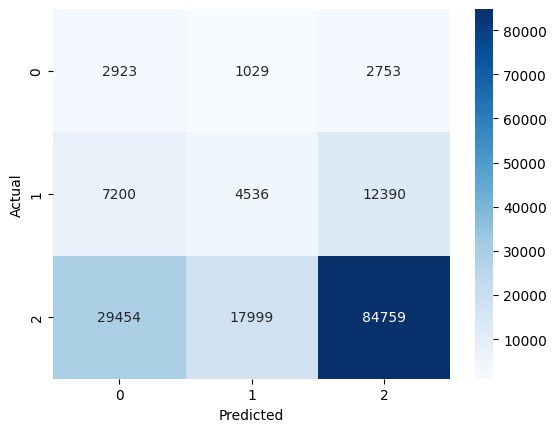

In [47]:
evaluate_model(model, test_loader)

In [48]:
# Сохраняем обученную модель для инференса
torch.save(model, 'NY_2015_model.pth')